In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

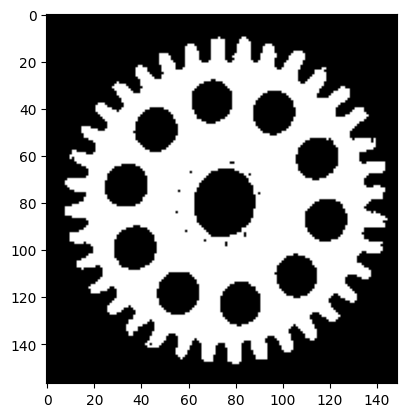

In [2]:
img = cv2.imread("trybik.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# bin_img = cv2.adaptiveThreshold(img, 200, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
bin_img = (img < 200).astype(np.uint8) * 255

plt.imshow(bin_img, cmap='gray')

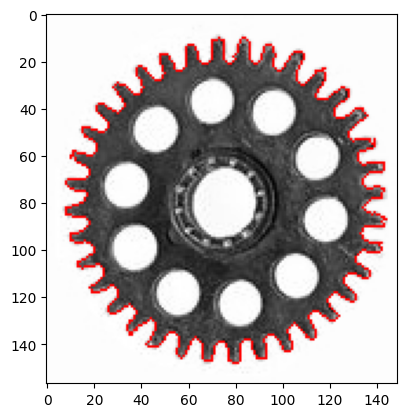

In [3]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

contours, hierarchy = cv2.findContours(bin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

cv2.drawContours(img_rgb, contours, 0, (255, 0, 0), 1)

plt.imshow(img_rgb)

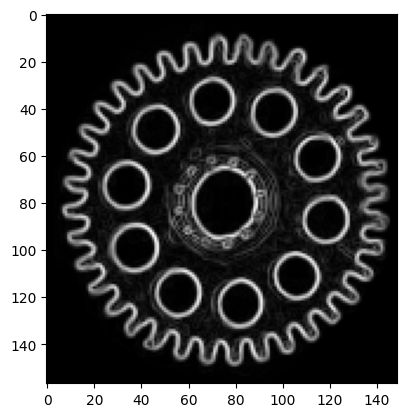

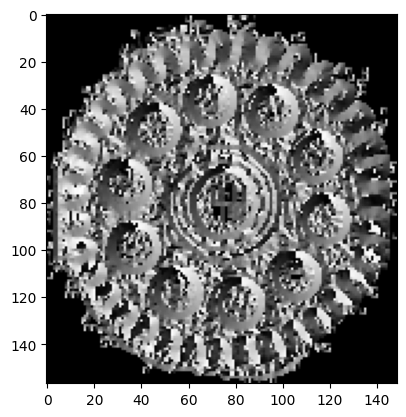

In [4]:
sobely = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobelx = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

sobel = np.sqrt(sobelx**2 + sobely**2)
# normalize
sobel = sobel/np.amax(sobel)

# gradient orientation
theta = ((np.degrees((np.arctan2(sobely, sobelx))) + 360) % 360).astype(np.int32)

plt.imshow(sobel, cmap='gray')
plt.show()
plt.imshow(theta, cmap='gray')
plt.show()


In [5]:
moments = cv2.moments(bin_img, True)
m00 = moments['m00']
m01 = moments['m01']
m10 = moments['m10']

# center of mass
center = (int(m01/m00), int(m10/m00))

In [6]:
pattern_x = np.linspace(0, img.shape[1] - 1, img.shape[1])
pattern_y = np.linspace(0, img.shape[0] - 1, img.shape[0])

pattern_dx = pattern_x - center[0]
pattern_dy = pattern_y - center[1]

matrix_pattern_dx = np.tile(pattern_dx, (img.shape[0], 1))
matrix_pattern_dy = np.tile(pattern_dy, (img.shape[1], 1)).T

pattern_distances = np.sqrt(matrix_pattern_dx ** 2 + matrix_pattern_dy ** 2)
pattern_angles = np.arctan2(matrix_pattern_dy, matrix_pattern_dx) + np.pi


In [7]:
R_table = [ [] for _ in range(360) ]

for contour in contours:
    for point in contour:
        (y, x) = point[0]
        radius = pattern_distances[x,y]
        alpha = pattern_angles[x,y]
        phi = theta[x,y]

        R_table[phi].append((radius, alpha))

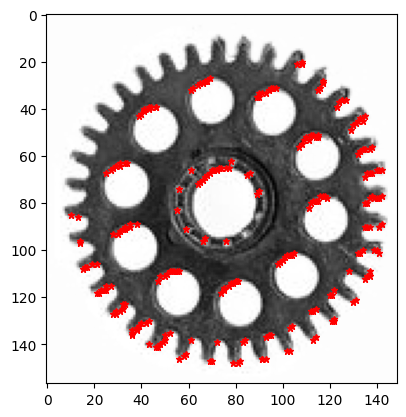

In [8]:
x_points = []
y_points = []

ang_range = 60

for th in range(ang_range):
    for r, alpha in R_table[th]:
        x = int(-r * np.cos(alpha) + center[0])
        y = int(-r * np.sin(alpha) + center[1])

        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            x_points.append(x)
            y_points.append(y)

plt.imshow(img, cmap='gray')
plt.plot(x_points, y_points, 'r*', markersize=5)
plt.show()

In [9]:
img2 = cv2.imread("trybiki2.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sobely2 = cv2.Sobel(img2, cv2.CV_64F, 1, 0, ksize=5)
sobelx2 = cv2.Sobel(img2, cv2.CV_64F, 0, 1, ksize=5)

sobel2 = np.sqrt(sobelx2**2 + sobely2**2)


# gradient orientation
theta2 = ((np.degrees(np.arctan2(sobely2, sobelx2)) + 360) % 360).astype(np.int32)

sobel2 /= np.amax(sobel2)


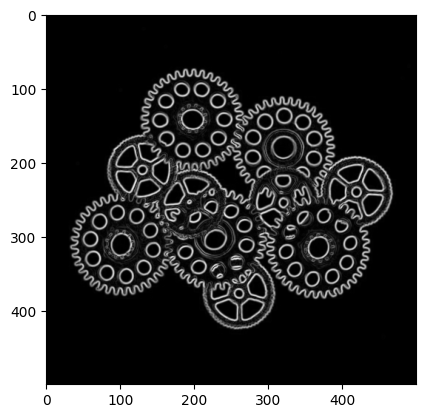

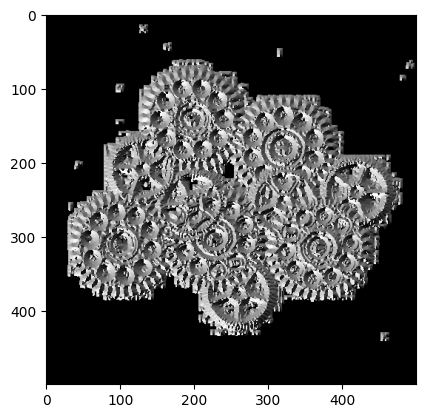

In [10]:
plt.imshow(sobel2, cmap='gray')
plt.show()

plt.imshow(theta2, cmap='gray')
plt.show()

In [11]:
H = np.zeros((img2.shape[0], img2.shape[1]), dtype=np.uint8)

is_edge_img = sobel2 > 0.5

for y in range(img2.shape[0]):
    for x in range(img2.shape[1]):
        if is_edge_img[y, x]:
            phi = theta2[y, x]
            
            for radius, alpha in R_table[phi]:
                x1 = int(radius * np.cos(alpha) + x)
                y1 = int(radius * np.sin(alpha) + y)

                if 0 <= y1 < img2.shape[0] and 0 <= x1 < img2.shape[1]:
                    H[y1, x1] += 1

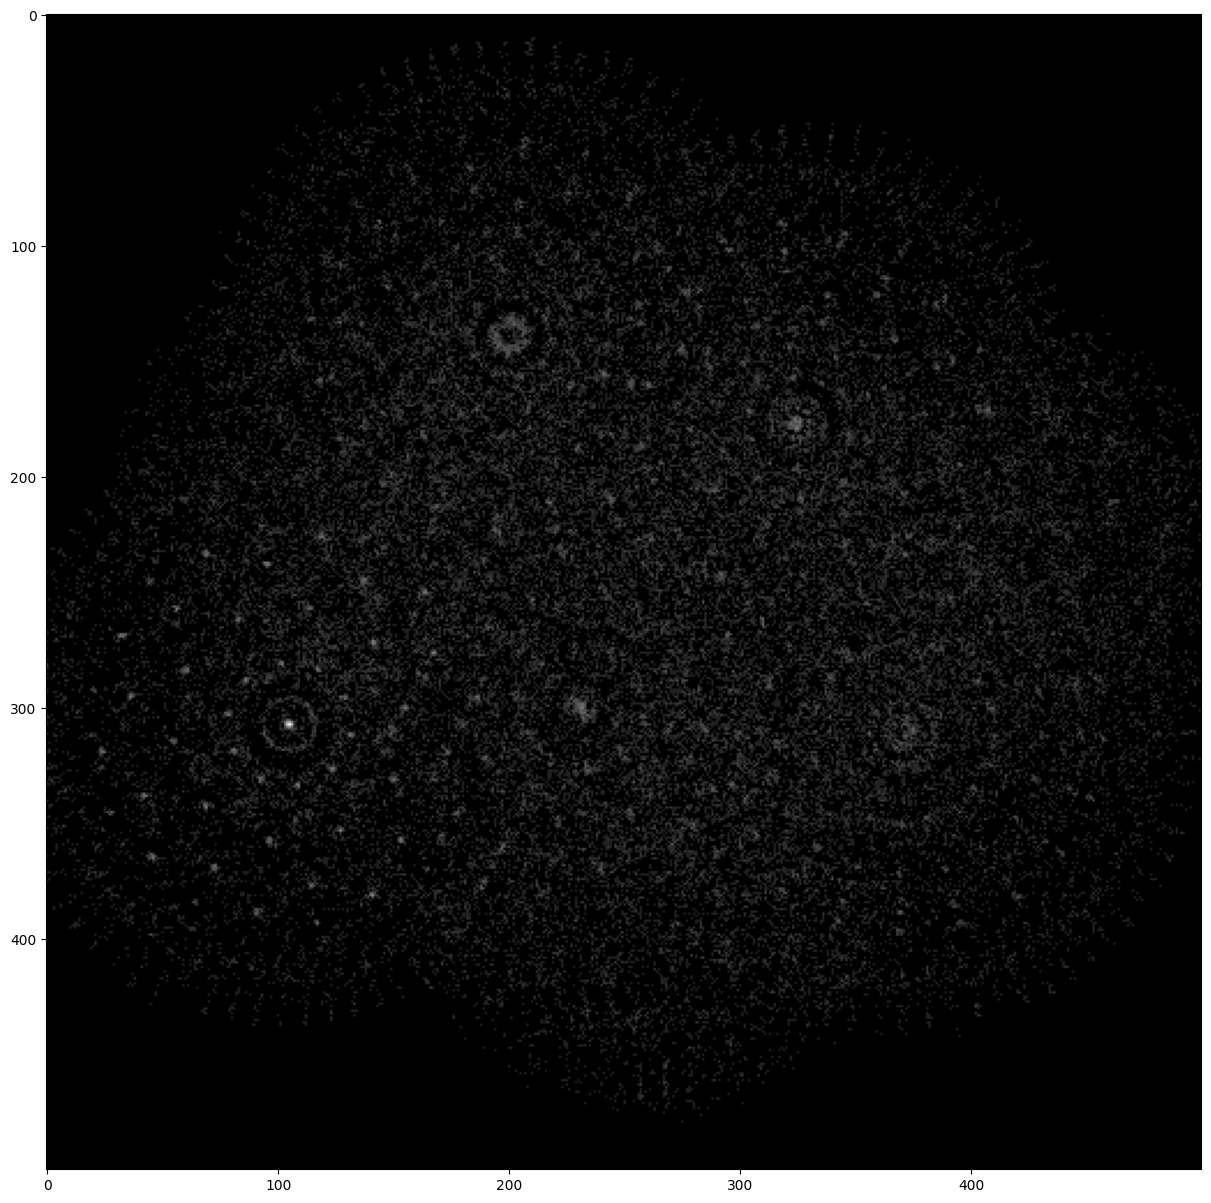

In [12]:
plt.figure(figsize=(15, 15))
plt.imshow(np.log(H + 1), cmap='gray')
plt.show()

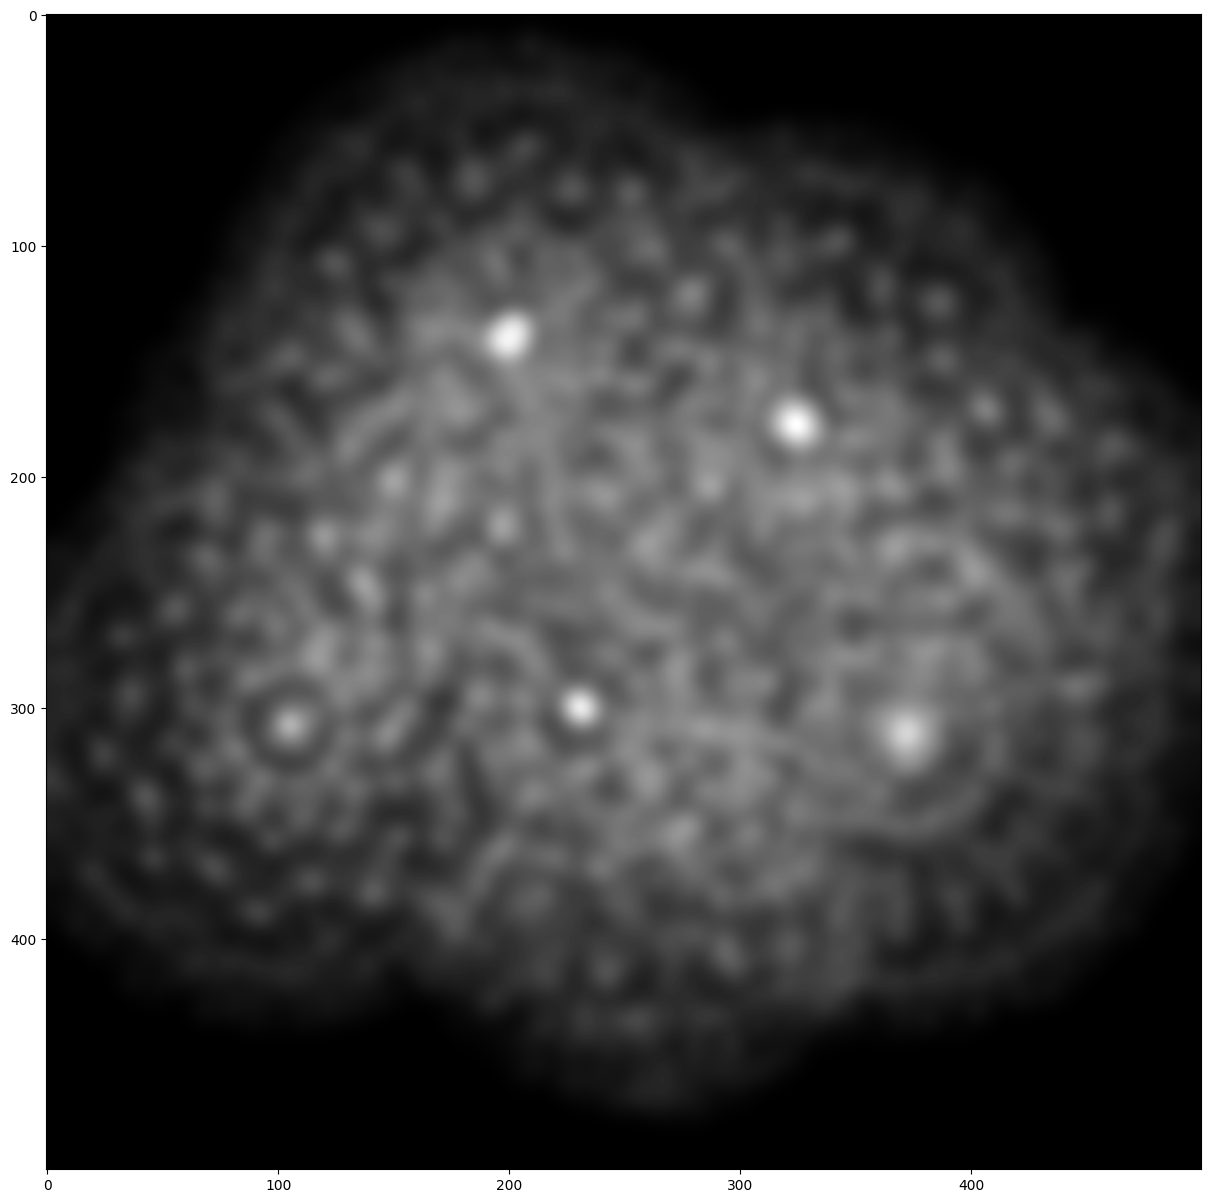

In [13]:
H = np.log(H + 1.0)
H = cv2.GaussianBlur(H, (37, 37), 5)

plt.figure(figsize=(15, 15))
plt.imshow(H, cmap='gray')
plt.show()


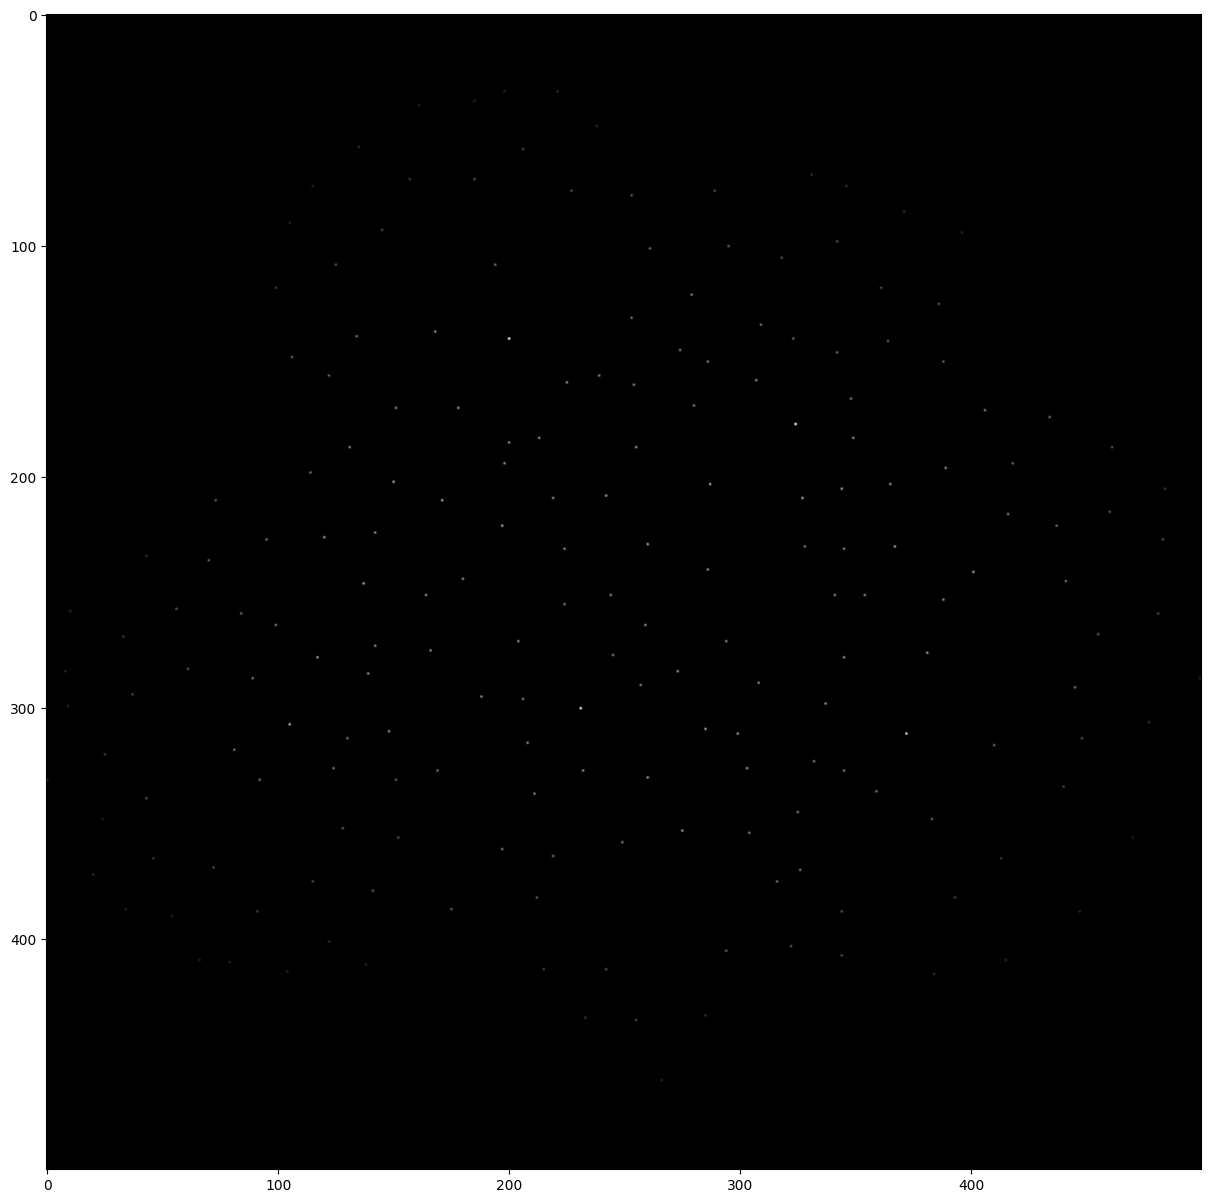

In [14]:
H_dilated = cv2.dilate(H, np.ones((17,17), np.uint8))
H_dilated = H * (H == H_dilated)

plt.figure(figsize=(15,15))
plt.imshow(H_dilated, cmap='gray')

In [15]:
max_x_points = []
max_y_points = []

for i in range(5):
    max_x, max_y = np.where(H_dilated == H_dilated.max())
    max_x_points.append(max_x[0])
    max_y_points.append(max_y[0])
    if isinstance(max_x, np.ndarray) and len(max_x) > 1:
        H_dilated[max_x[0], max_y[0]] = 0
    else:
        H_dilated[max_x, max_y] = 0

(324, 177)
(200, 140)
(231, 300)
(372, 311)
(105, 307)


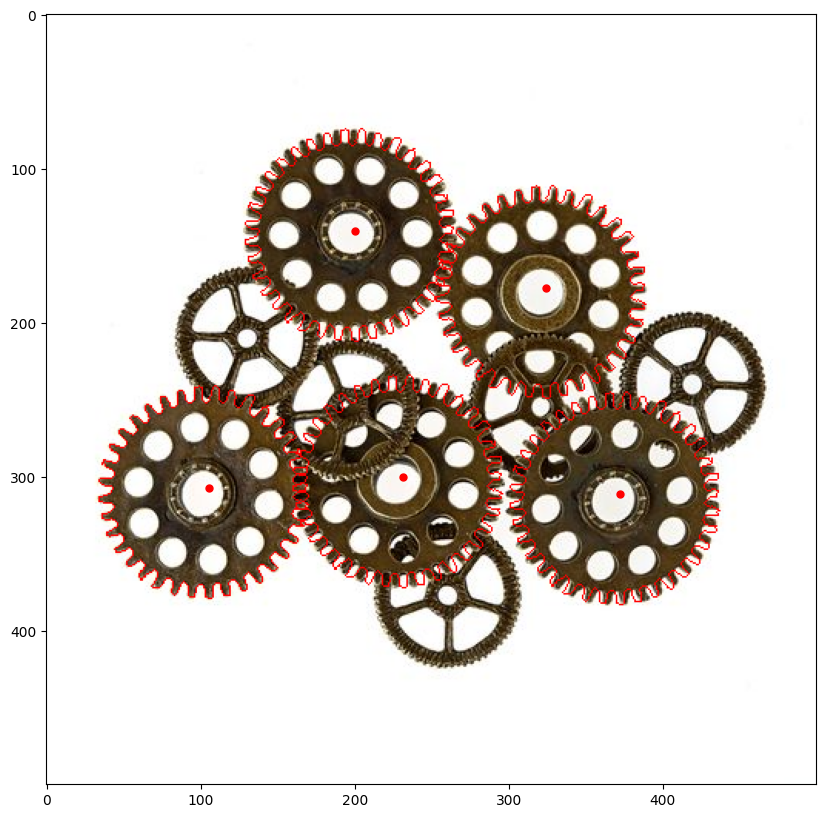

In [16]:
contours_img = cv2.imread("trybiki2.jpg")

plt.figure(figsize=(10,10))
plt.imshow(img2, cmap='gray')
for point in zip(max_y_points, max_x_points):
    plt.plot(point[0], point[1], 'ro', markersize=5)
    print(point)
    contours_img = cv2.drawContours(contours_img, contours[0] + np.array(point) - center, -1, (0, 0, 255), 1)
# convert from bgr to rgb
contours_img = cv2.cvtColor(contours_img, cv2.COLOR_BGR2RGB)
plt.imshow(contours_img)